## Explore dataset

In [19]:
import os

Load the metadata file into a pandas DataFrame.

In [20]:
import numpy as np
import pandas as pd

products_metadata = pd.read_pickle('/shared_dir/notebooks/files_metadata.pickle')
products_metadata[0]

{'_id': {'$oid': '6277da7659de28212c0b872a'},
 'datasetId': 'MRO_CTX',
 'productDate': '2006-11-18T11:22:44Z',
 'productId': 'P01_001463_2077_XN_27N264W.tif',
 'version': 'npt05',
 'EmissionAngle': 0.08,
 'IncidenceAngle': 48.52,
 'MapScale': 5.66,
 'ObservationTime': '2006-11-18T11:22:55.215',
 'PhaseAngle': 48.51,
 'geometry': {'geometries': [{'type': 'Polygon',
    'coordinates': [[[95.0097617, 26.9026088],
      [95.6986405, 26.9026088],
      [95.7061593, 28.0811555],
      [95.0098667, 28.0811555],
      [95.0097617, 26.9026088]]]}],
  'type': 'GeometryCollection'},
 'insertDate': '2022-05-08T14:57:58Z',
 'instrument': 'CONTEXT CAMERA',
 'instrumentId': 'CTX',
 'mission': 'MARS RECONNAISSANCE ORBITER',
 'missionId': 'MRO',
 'observationMode': 'EDR',
 'status': '',
 'targetName': 'MARS'}

From metadata extract all regions patches and store in longitude/latitude dictionary.

In [21]:
def compute_aprox_center(coords):
    #print("next",coords.shape)
    ys = sorted(coords[:,1])
    xs = sorted(coords[:,0])
    #print(coords)
    #print(ys)
    #print(xs)
    center_approx = ((xs[3]+xs[1])/2,(ys[3]+ys[1])/2)
    #print(center_approx)
    return center_approx

In [22]:
products_id = [md["productId"] for md in products_metadata]
products_geom = [md["geometry"]["geometries"][0] for md in products_metadata]
products_geom_coordinates = [md["coordinates"][0] for md in products_geom]
products_geom_centers = [compute_aprox_center(np.array(md["coordinates"][0][1:])) for md in products_geom ]
# create dictionary of ordered coordinates
coordinates = {"lon": [], "lat": []}
for el in products_geom_coordinates:
    for item in el:
        coordinates["lon"].append(item[0])
        coordinates["lat"].append(item[1])

Plot the regions for a subset of the dataset (dataset contains 905 polygonal patches, we print the first 100).

Text(0, 0.5, 'longitude')

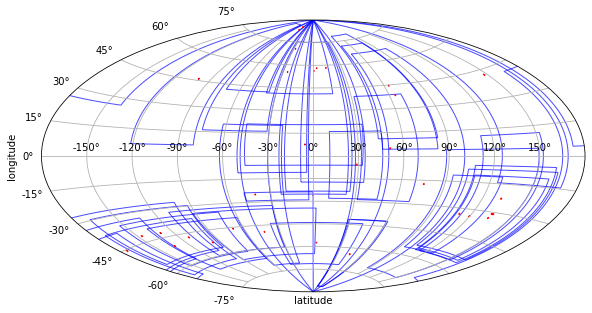

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(projection="aitoff")
ax.grid(True)

for el in products_geom_coordinates[:50]:
    ax.add_patch(patches.Polygon(el, closed=True, fc=None, ec="b", fill=False, alpha=0.7))

for cent in products_geom_centers[:50]:
    ax.add_patch(patches.Rectangle(cent, 0.01,0.01, color="red"))
    
    
ax.set_xlabel("latitude")
ax.set_ylabel("longitude")

Load geojson regions that we know contains areas with high crater density and overlay the dataset images patches. Use GeoPandas with inbuilt projection.

In [24]:
for geo in geo_regions[0:1]:
    df = gpd.read_file(join('/shared_volume/geometries/', geo))
    print(df.columns)
    print(df["geometry"])

Index(['name', 'geometry'], dtype='object')
0    POLYGON ((26.70435 -51.84561, -39.31091 -51.84...
Name: geometry, dtype: geometry


<IPython.core.display.Javascript object>


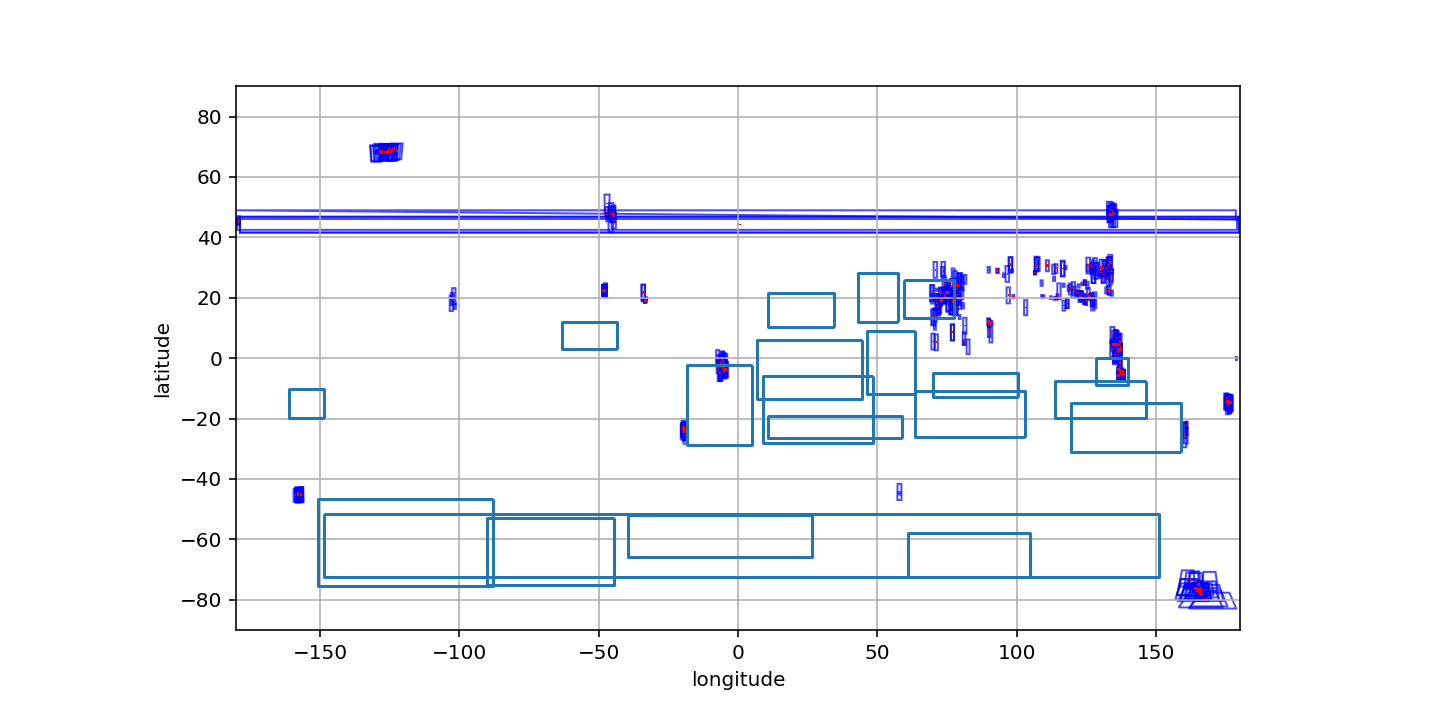

In [25]:
import geopandas as gpd
from os import listdir
from os.path import join
%matplotlib notebook
geo_regions = listdir('/shared_volume/geometries/')

fig = plt.figure(figsize=(10, 5))
#ax = plt.subplot(projection="aitoff")
ax = plt.subplot()
ax.grid(True)

ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_ylim([-90, 90])
ax.set_xlim([-180, 180])

# blue
for geo in geo_regions:
    df = gpd.read_file(join('/shared_volume/geometries/', geo))
    df.boundary.plot(ax=ax, fc='none')
        
# purple
for el in products_geom_coordinates:
    ax.add_patch(patches.Polygon(el, closed=True, fc=None, ec="b", fill=False, alpha=0.7, color="red"))

for cent in products_geom_centers:
    ax.add_patch(patches.Rectangle(cent, 0.1,0.1, color="red"))
    

Create GeoDataFrames from preselected geometries containing craters and dataset geometries. This should help filtering the dataset via intersection or overlap in order to filter out areas with small craters density.

In [40]:
from shapely.geometry import Polygon

p1_list, p1_id = [], []
for geo in geo_regions:
    df = gpd.read_file(join('/shared_volume/geometries/', geo))
    p1_list.append([item for item in df.geometry][0])
    p1_id.append(df.name[0])
    
p1 = gpd.GeoSeries(p1_list, crs="EPSG:4326")
rois = gpd.GeoDataFrame({'geometry': p1, 'id': p1_id})

p2_list = []
for el in products_geom_coordinates:
    p2_list.append([Polygon([(item[0], item[1]) for item in el])][0])
    
p2 = gpd.GeoSeries(p2_list, crs="EPSG:4326")
imgs = gpd.GeoDataFrame({'geometry': p2, 'id': products_id})

rois.head(), imgs.head()

(                                            geometry          id
 0  POLYGON ((26.70435 -51.84561, -39.31091 -51.84...  Geometry12
 1  POLYGON ((100.36193 -12.73493, 100.36193 -5.02...   Geometry4
 2  POLYGON ((102.88793 -26.01929, 102.88793 -10.7...   Geometry5
 3  POLYGON ((-44.52324 -52.96351, -90.04818 -52.9...  Geometry13
 4  POLYGON ((-43.42005 3.06649, -43.42005 12.1230...  Geometry18,
                                             geometry  \
 0  POLYGON ((95.00976 26.90261, 95.69864 26.90261...   
 1  POLYGON ((122.98032 20.56257, 123.68478 20.562...   
 2  POLYGON ((133.49006 47.05846, 134.55690 47.058...   
 3  POLYGON ((137.38463 -6.79135, 138.17398 -6.791...   
 4  POLYGON ((-126.45577 69.00789, -125.09355 69.0...   
 
                                id  
 0  P01_001463_2077_XN_27N264W.tif  
 1  P01_001462_2017_XI_21N236W.tif  
 2  P01_001435_2280_XI_48N226W.tif  
 3  P01_001422_1747_XN_05S222W.tif  
 4  P01_001418_2494_XI_69N125W.tif  )

Intersection allows to define the areas of geometry which are contained by both sets. The issue is that it works row by row, one geometry against the other. Given that we have 20 region of interest against 905 images, the intersection ends up empy. We should find a solution that performs the intersection in each permutation of the two dataframes.

In [41]:
intersected = rois.intersection(imgs, align=True)     
intersected[~intersected.is_empty][~intersected.isna()]

/opt/venv/adamapienv/lib/python3.8/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/tmp/ipykernel_13/3069809291.py:2: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  intersected[~intersected.is_empty][~intersected.isna()]


GeoSeries([], dtype: geometry)

The same as for the intersection can be said about the <code>contains</code> method.

In [42]:
contained = df1.contains(df2, align=True)     
contained[~contained == False]

/opt/venv/adamapienv/lib/python3.8/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


Series([], dtype: bool)

Let's try to iterate the intersection geometry-wise and save the intersection in a new GeoDataFrame

In [ ]:
intersected_list, intersected_ids = [], []
for geo in geo_regions:
    df = gpd.read_file(join('/shared_volume/geometries/', geo))
    roi = gpd.GeoSeries([item for item in df.geometry][0], crs="EPSG:4326")

    for idx, el in enumerate(products_geom_coordinates):
        img = gpd.GeoSeries([Polygon([(item[0], item[1]) for item in el])][0], crs="EPSG:4326")

        intersected = roi.intersection(img)
        if not intersected.is_empty.any():
            intersected_list.append(intersected)
            intersected_ids.append(products_id[idx])

intersected_series = gpd.GeoSeries(intersected_list, crs="EPSG:4326")
intersected_df = gpd.GeoDataFrame({'geometry': intersected_series, 'id': intersected_ids})
            
intersected_df.head()